# Libraries

In [1]:
# import json file called config
import json
with open('config.json') as f:
    config = json.load(f)
TOKENIZER_ID = config['TOKENIZER_ID']
nrows = None if config['nrows'] == 0 else config['nrows']
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, confusion_matrix, roc_auc_score, roc_curve # this is used to evaluate the model.
from sklearn.model_selection import train_test_split # to separate the dataset.
from transformers import BertTokenizer, BertModel
from sklearn.tree import DecisionTreeClassifier
import time #pour étudier le temps d'execution d'entrainement, de notre meilleure modèle.
import psutil #pour calculer la mémoire.
import os #pour calculer le temps d'execution
import ast

# Data access

In [2]:
# data=pd.read_csv('title_text.csv',nrows=nrows)
# #check if isFake column has unique values
# print(data['isFake'].value_counts())

In [3]:
# data.dropna(inplace=True)

In [4]:
data=pd.read_csv('x_y_dataset.csv',nrows=nrows)
X = data['X']
y = data['y']

# Convert the string representation of the list into a list of integers
X = X.apply(lambda x: ast.literal_eval(x))

# Convert the list of lists into a numpy array
X = np.array(X.tolist())
y = data['y']

X
# X is a dataframe with the data of the form : [101, 2202, 2117, 6221, 8398, 270...] transform it into numpy array
y = np.array(y)

## Modification du text en données numériques. (BERT)
Nous partons du principe que les données ont étés clean et que nous pouvons nous concerntrer à créer un model.

Comme les informations principales pour définir des Fake news et des vrai news, se base sur le texte et le titre, nous devons nous focaliser sur ces informations. Il faut ainsi que nous transformons le text et le titre en données afin que notre model puisse utiliser des données numériques pour trouver la bonne réponse. Nous allons utiliser le BERT tokenizer.

In [5]:
# X = data['text_processed']

# # Create the tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# model_bert = BertModel.from_pretrained('bert-base-uncased')

# # Set the maximum sequence length
# max_seq_length = 512

# # Truncate or pad the tokenized sequences
# X = X.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_seq_length, truncation=True, padding='max_length'))
# print(X)
# y = data['isFake'].astype(int) #make it numerical
# print(y.value_counts())

# data split

In [6]:
# we separate the trdata into training test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train = np.array(X_train.tolist())
y_train= np.array(y_train.tolist())
print(X_train.shape,y_train.shape)

X_test = np.array(X_test.tolist())
y_test= np.array(y_test.tolist())
print(X_test.shape,y_test.shape)

X_validation = np.array(X_validation.tolist())
y_validation= np.array(y_validation.tolist())
print(X_validation.shape,y_validation.shape)

(33309, 512) (33309,)
(4164, 512) (4164,)
(4164, 512) (4164,)


# model decision tree
Un arbre de décision est une technique d'apprentissage supervisé utilisée pour résoudre des problèmes de classification et de régression. Il vise à modéliser la relation entre une variable cible, qui dans notre cas sont les Fake news, et plusieurs variables explicatives, dans ce cas nous utiliserons le texte de la news en question.

L'approche de l'arbre de décision suit la stratégie de **"diviser pour conquérir"**.

Cet algorithme itératif construit progressivement l'arbre. Au départ, il sélectionne l'attribut qui divise le mieux les données, formant des groupes en relation avec la variable cible. À chaque étape suivante, il répète ce processus pour chaque sous-ensemble créé précédemment, en se basant sur les nœuds déjà formés, jusqu'à ce que les critères de terminaison soient satisfaits (ex: le nombre maximal de niveaux dans l'arbre)

Une fois l'arbre construit, il peut être utilisé pour prédire l'issue pour de nouvelles données en les faisant passer à travers l'arbre, de la racine jusqu'à une feuille, qui représente la décision finale ou la prédiction de la variable cible.

src: https://scikit-learn.org/stable/modules/tree.html

In [7]:
#nous construisons le modèle
clf = DecisionTreeClassifier(max_depth=1,random_state=42)
#nous l'entrainons
clf.fit(X_train, y_train)

#nous obtenons une accuracy du modèle
Accuracy = clf.score(X_test, y_test)
print("Accuracy Test Data: "+str(round(Accuracy*100,2))+"%")

Accuracy Test Data: 78.58%


In [8]:
y_pred_validation=clf.predict(X_validation)

# we calculate the accuracy of the model on the validation data
accuracy_validation=accuracy_score(y_validation, y_pred_validation)
print("Accuracy Validation Data: "+str(round(accuracy_validation*100,2))+"%")

Accuracy Validation Data: 78.67%


# Model Optimisation
Pour optimiser le model nous allons modifier les paramètres suivants:
- **criterion**: Comme son nom l'indique c'est le critère de qualité que notre modèle utilise pour séparer les données et de créer les noeuds. Nous allons optimiser le modèle avec les valeurs suivantes: **[“gini”, “entropy”, “log_loss”]**
- **max_depth**: la profondeur maximale que nous autorisons à notre arbre. Nous allons optimiser le modèle avec les valeurs suivantes: **[10,100,1000,None]**
- **splitter**: C'est la stratégie que notre modèle utilise pour créer les noeuds. Nous allons optimiser le modèle avec les valeurs suivantes: **[“best”, “random”]**

In [9]:
params_grid={'criterion':["gini", "entropy"],
             'max_depth':[5,10,50,100,1000,5000],
             'splitter': ["best", "random"]
            }

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score


# Initialize the Decision tree classifier, with early stopping 


model = DecisionTreeClassifier(random_state=42,)

# On creer un scorer pour le grid search 
scorer = make_scorer(accuracy_score)

# Initialisation de la GridSearch pour trouver les meilleurs parametres.
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=params_grid, # parametres à tester
    scoring=scorer, # scorer
    cv=5, # cv=5 pour utiliser la validation croisée à 5 folds 
    verbose=2, # verbose=2 pour afficher les logs
    n_jobs=-1, # n_jobs=-1 pour utiliser tous les coeurs du CPU
    return_train_score=True # pour afficher les scores d'entrainement
    )
# On lance les multiples entrainements.
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 1000, 5000],
                         'splitter': ['best', 'random']},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'),
             verbose=2)

In [11]:
# Get the best combination of parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}
Best score: 0.9845086020505601


# Model Evaluation
Afin d'évaluer le modèle nous faisons une représentation graphique des résultats obtenus. Nous allons étudier les metrics suivants:
- le **temps d'entrainement** que le modèle a besoin, ainsi que son **taux de mémoire (Mo)**.
- **matrice de confusion**, qui est un excellent choix d'évaluation de performance, car nous sommes dans le cas d'une classification binaire. 
- **L'accuracy** du model.
- **La précision**
- **recall**
- **F1-score**.
- **ROC-AUC score**

src: https://www.v7labs.com/blog/performance-metrics-in-machine-learning#h2

In [12]:
# On recupere le meilleur modele
best_model = grid_search.best_estimator_

Nous voullons étudier **le temps d'entrainement (en h/m/s)** et **l'utilisation de la mémoire (Mo)** que le modèle a besoin.

In [13]:
def second_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)

def bytes_to_Mo(mem_bytes):
    mem_kb = mem_bytes / 1024  # Convertir en kilooctets
    mem_mb = mem_kb / 1024  # Convertir en mégaoctets
    return mem_mb

#lancemenet de l'enrestristrement de la mémoire.
process = psutil.Process(os.getpid())
mem_before_bytes = process.memory_info().rss

#lancement de l'enregistrement du temps d'entrainement.
start_time = time.time() 
# entrainement du modèle.
best_model.fit(X_train,y_train)
end_time = time.time()

#le temps écoulé 
elapsed_time= end_time - start_time

print(f"Temps d'entrainement (h | m | s) : {second_to_hms(elapsed_time)[0]} | {second_to_hms(elapsed_time)[1]} | {second_to_hms(elapsed_time)[2]}")

mem_after_bytes = process.memory_info().rss
#on convertit les bytes en Mo.
mem_bytes=mem_after_bytes - mem_before_bytes


print(f"Utilisation de la mémoire (Mo) : {bytes_to_Mo(mem_bytes)}")

Temps d'entrainement (h | m | s) : 0 | 0 | 6
Utilisation de la mémoire (Mo) : 0.00390625


In [14]:
# On predit les donnees de test
y_pred = best_model.predict(X_test)

In [15]:
# On calcule l'accuracy
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Accuracy Test Data: {round(accuracy_test*100,2)}%")

Accuracy Test Data: 98.58%


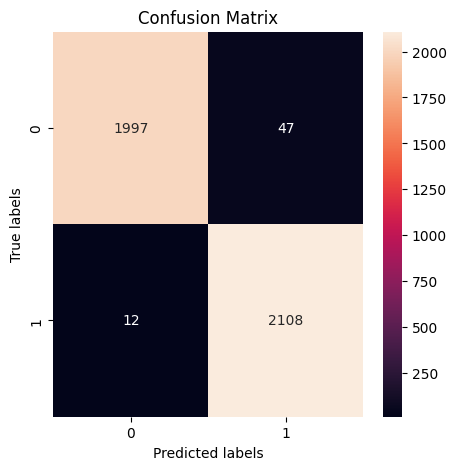

le modèle a donc 1997 instances vrai Positives et 2108 instances de Vrai négatives, 12 instances de Faux Positives et 47 instances de Faux négatives. 


In [16]:
# On affiche la matrice de confusion en utilisant matplotlib
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d',)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print(f"le modèle a donc {cm[0][0]} instances vrai Positives et {cm[1][1]} instances de Vrai négatives, {cm[1][0]} instances de Faux Positives et {cm[0][1]} instances de Faux négatives. ")

In [17]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
# Calculate the percentage of True Positive, True Negative, False Positive, and False Negative
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {round(true_negative_percentage,2)}%")
print(f"False Positive: {round(false_positive_percentage,2)}%")
print(f"False Negative: {round(false_negative_percentage,2)}%")
print(f"True Positive: {round(true_positive_percentage,2)}%")

True Negative: 47.96%
False Positive: 1.13%
False Negative: 0.29%
True Positive: 50.62%


In [18]:
acc=accuracy_score(y_pred,y_test)
print(f"Notre modèle a une précision globale de {round(acc*100,2)}%, ce qui signifie qu'il prédit correctement les classes des instances dans {round(acc*100,2)}% des cas.")

Notre modèle a une précision globale de 98.58%, ce qui signifie qu'il prédit correctement les classes des instances dans 98.58% des cas.


In [19]:
precision=precision_score(y_test,y_pred)
print(f"notre model a une precision de {round(precision*100,2)}% . lorsqu'il prédit une classe comme positive, il a raison dans {round(precision*100,2)}% des cas.")

notre model a une precision de 97.82% . lorsqu'il prédit une classe comme positive, il a raison dans 97.82% des cas.


In [20]:
recall=recall_score(y_test,y_pred)
print(f"notre model arrive a détecter {round(recall*100,2)}%. Donc sur l'ensemble des vrai positives, le modèle parvient à en identifier correctement {round(recall*100,2)}% des cas.")

notre model arrive a détecter 99.43%. Donc sur l'ensemble des vrai positives, le modèle parvient à en identifier correctement 99.43% des cas.


In [21]:
f1score=f1_score(y_test,y_pred)
print(f"notre model a un F1-score de {round(f1score*100,2)}%, ce qui signifie que il y a un excellent equilibre entre le recall et la précision.")

notre model a un F1-score de 98.62%, ce qui signifie que il y a un excellent equilibre entre le recall et la précision.


In [22]:
roc_auc=roc_auc_score(y_test,y_pred)
print(f"Le modèle a donc une score ROC-AUC de {roc_auc} ce qui est très proche de 1, donc le modèle a une excellente capacité à différencier entres les Fake et les vrais news.")

Le modèle a donc une score ROC-AUC de 0.9856727467414984 ce qui est très proche de 1, donc le modèle a une excellente capacité à différencier entres les Fake et les vrais news.


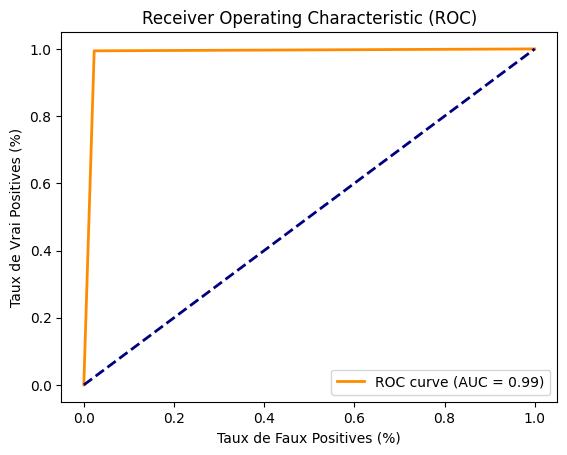

In [23]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positives (%)')
plt.ylabel('Taux de Vrai Positives (%)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [24]:
# On predit les donnees de validation
y_pred_validation = best_model.predict(X_validation)
# On calcule l'accuracy
accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f"Accuracy Validation Data: {accuracy_validation*100}%")

Accuracy Validation Data: 98.4630163304515%


# Test de performances sur des données générées par Téléchargé ailleurs

In [25]:
# Prepare the data
validation_data=pd.read_csv("data/valid_clean.csv",nrows=nrows)
#remove nan values
validation_data=validation_data.dropna()
validation_data=validation_data[['text_processed','isFake']]
validation_data.head()

validation_data_X = validation_data['text_processed']
validation_data_y = validation_data['isFake'].astype(int)

#load the bert_tockenizer.pickle into a variable called tokenizer
import pickle as pkl
with open('bert_tokenizer.pickle', 'rb') as f:
    tokenizer = pkl.load(f)

# Tokenize the data using the BERT tokenizer
encoded_inputs = tokenizer(validation_data_X.tolist(), padding=True, truncation=True, max_length=512, return_tensors='np')

# Get the input IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Use the trained model to make predictions on the dataset
predictions = best_model.predict(input_ids)


In [26]:
# validation_data=pd.read_csv("data/validation_data.csv",nrows=nrows)
# validation_data=validation_data[['text','isFake']]

# # Prepare the data
# validation_data_X = validation_data['text'].apply(lambda x: x.lower())  # the text data
# validation_data_y = validation_data['isFake']

# # Tokenize the data using the BERT tokenizer
# encoded_inputs = tokenizer(validation_data_X.tolist(), padding=True, truncation=True, max_length=max_seq_length, return_tensors='np')

# # Get the input IDs and attention masks
# input_ids = encoded_inputs['input_ids']
# attention_masks = encoded_inputs['attention_mask']

# # Use the trained model to make predictions on the dataset
# predictions = best_model.predict(input_ids)


In [27]:
#we print the accuracy of the model
accuracy = accuracy_score(validation_data_y, predictions)
print(f"Accuracy different Dataset: {round(accuracy*100,2)}%")

Accuracy different Dataset: 49.34%


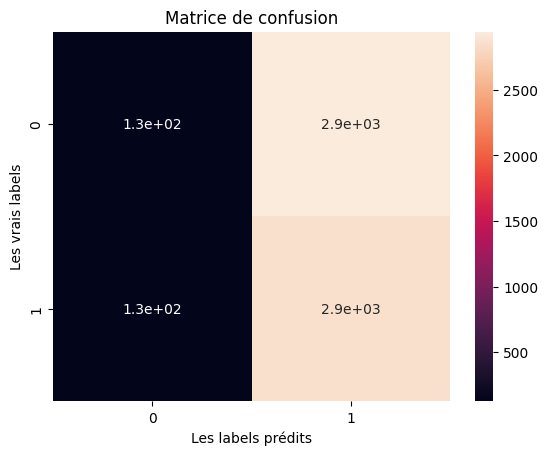

In [28]:
cm = confusion_matrix(validation_data_y,predictions)
#représentation graphique du résultat du meilleure model
sns.heatmap(cm, annot=True)
plt.xlabel('Les labels prédits')
plt.ylabel('Les vrais labels')
plt.title('Matrice de confusion')
plt.show()

In [29]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
# Calculate the percentage of True Positive, True Negative, False Positive, and False Negative
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {round(true_negative_percentage,2)}%")
print(f"False Positive: {round(false_positive_percentage,2)}%")
print(f"False Negative: {round(false_negative_percentage,2)}%")
print(f"True Positive: {round(true_positive_percentage,2)}%")

True Negative: 2.08%
False Positive: 48.58%
False Negative: 2.08%
True Positive: 47.26%


# Conclusion